In [1]:
# python 3.10.14
import seaborn as sns # 0.13.2
import matplotlib.pyplot as plt # 3.8.4
import numpy as np  # 1.23.2
import pandas as pd # 2.2.2


# to make this notebook's output stable across runs (still not fully deterministic)
SEED = 42
np.random.seed(SEED)


#articles link
#https://link.springer.com/article/10.1007/s00405-023-08299-w#Sec2 #dataset paper
#https://www.mdpi.com/2079-9292/10/16/1973 #greed search



https://link.springer.com/article/10.1007/s00405-023-08299-w#Sec2 #dataset paper
- UCI data n=383
- feature selection
- high scores
- hp tuning?

https://www.mdpi.com/2673-9585/4/4/29
- UCI data n=383
- SMOTE over-smpling
- HP tuning on test set?
- Very high scores 


https://arxiv.org/abs/2410.10907
- UCI data n=383
- DeepNN
- 80-20
- high scores
- LIME and Morris XAI
- no HP tuning

https://bmccancer.biomedcentral.com/articles/10.1186/s12885-024-12146-4
- china datset ~2000
- low scores
- different features
  

https://www.nature.com/articles/s41598-021-84504-2#Sec2
- other data ~1000
- low scores
- no HP tuning



https://www.mdpi.com/2079-9292/10/16/1973 #greed search



https://medium.com/@emilykmarsh/xgboost-feature-importance-233ee27c33a4 Why SHAP on XGBoost?


https://www.sciencedirect.com/science/article/abs/pii/S0957417421006540 Why nested Cv is overzealus

In [2]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18
#
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Define the colors for the plots
BACKGROUND_COL = '#F2F2F2'
AXIS_COLOR     = '#BEBEBE' 
LINES_COLOR    = '#BEBEBE'
sns.set_style("whitegrid", {'grid.linestyle': '--',
                            'grid.color': LINES_COLOR,
                            'axes.edgecolor': AXIS_COLOR,
                            'axes.facecolor':BACKGROUND_COL,
                            'figure.facecolor':BACKGROUND_COL,
                            })
plt.rcParams['axes.facecolor'] = BACKGROUND_COL

%matplotlib inline
%config InlineBackend.figure_format='retina' 

### Data downloading

In [3]:
#! mkdir -p data
#! wget "https://archive.ics.uci.edu/static/public/915/differentiated+thyroid+cancer+recurrence.zip"
#! unzip *.zip -d ./data
#! rm -f *.zip

In [4]:
DATA = pd.read_csv('./data/Thyroid_Diff.csv')
# check nan in dataframe
assert DATA.isna().sum().sum() == 0
DATA.columns

Index(['Age', 'Gender', 'Smoking', 'Hx Smoking', 'Hx Radiothreapy',
       'Thyroid Function', 'Physical Examination', 'Adenopathy', 'Pathology',
       'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response', 'Recurred'],
      dtype='object')

In [5]:
# Define a dictionary of column names and their corresponding custom orders
custom_orders = {
    'Stage': ['I', 'II', 'III', 'IVA', 'IVB'],
    'N': ['N0', 'N1a', 'N1b'],
    'T': ['T1a', 'T1b', 'T2', 'T3a', 'T3b', 'T4a', 'T4b'],
    'Risk': ['Low', 'Intermediate', 'High'],
    'Recurred': ['Yes', 'No']
}

# Apply the custom orders using a for loop
for col, order in custom_orders.items():
    DATA[col] = pd.Categorical(DATA[col], categories=order, ordered=True)
    print(f"{col} dtype: {DATA[col].unique()}")


Stage dtype: ['I', 'II', 'IVB', 'III', 'IVA']
Categories (5, object): ['I' < 'II' < 'III' < 'IVA' < 'IVB']
N dtype: ['N0', 'N1b', 'N1a']
Categories (3, object): ['N0' < 'N1a' < 'N1b']
T dtype: ['T1a', 'T1b', 'T2', 'T3a', 'T3b', 'T4a', 'T4b']
Categories (7, object): ['T1a' < 'T1b' < 'T2' < 'T3a' < 'T3b' < 'T4a' < 'T4b']
Risk dtype: ['Low', 'Intermediate', 'High']
Categories (3, object): ['Low' < 'Intermediate' < 'High']
Recurred dtype: ['No', 'Yes']
Categories (2, object): ['Yes' < 'No']


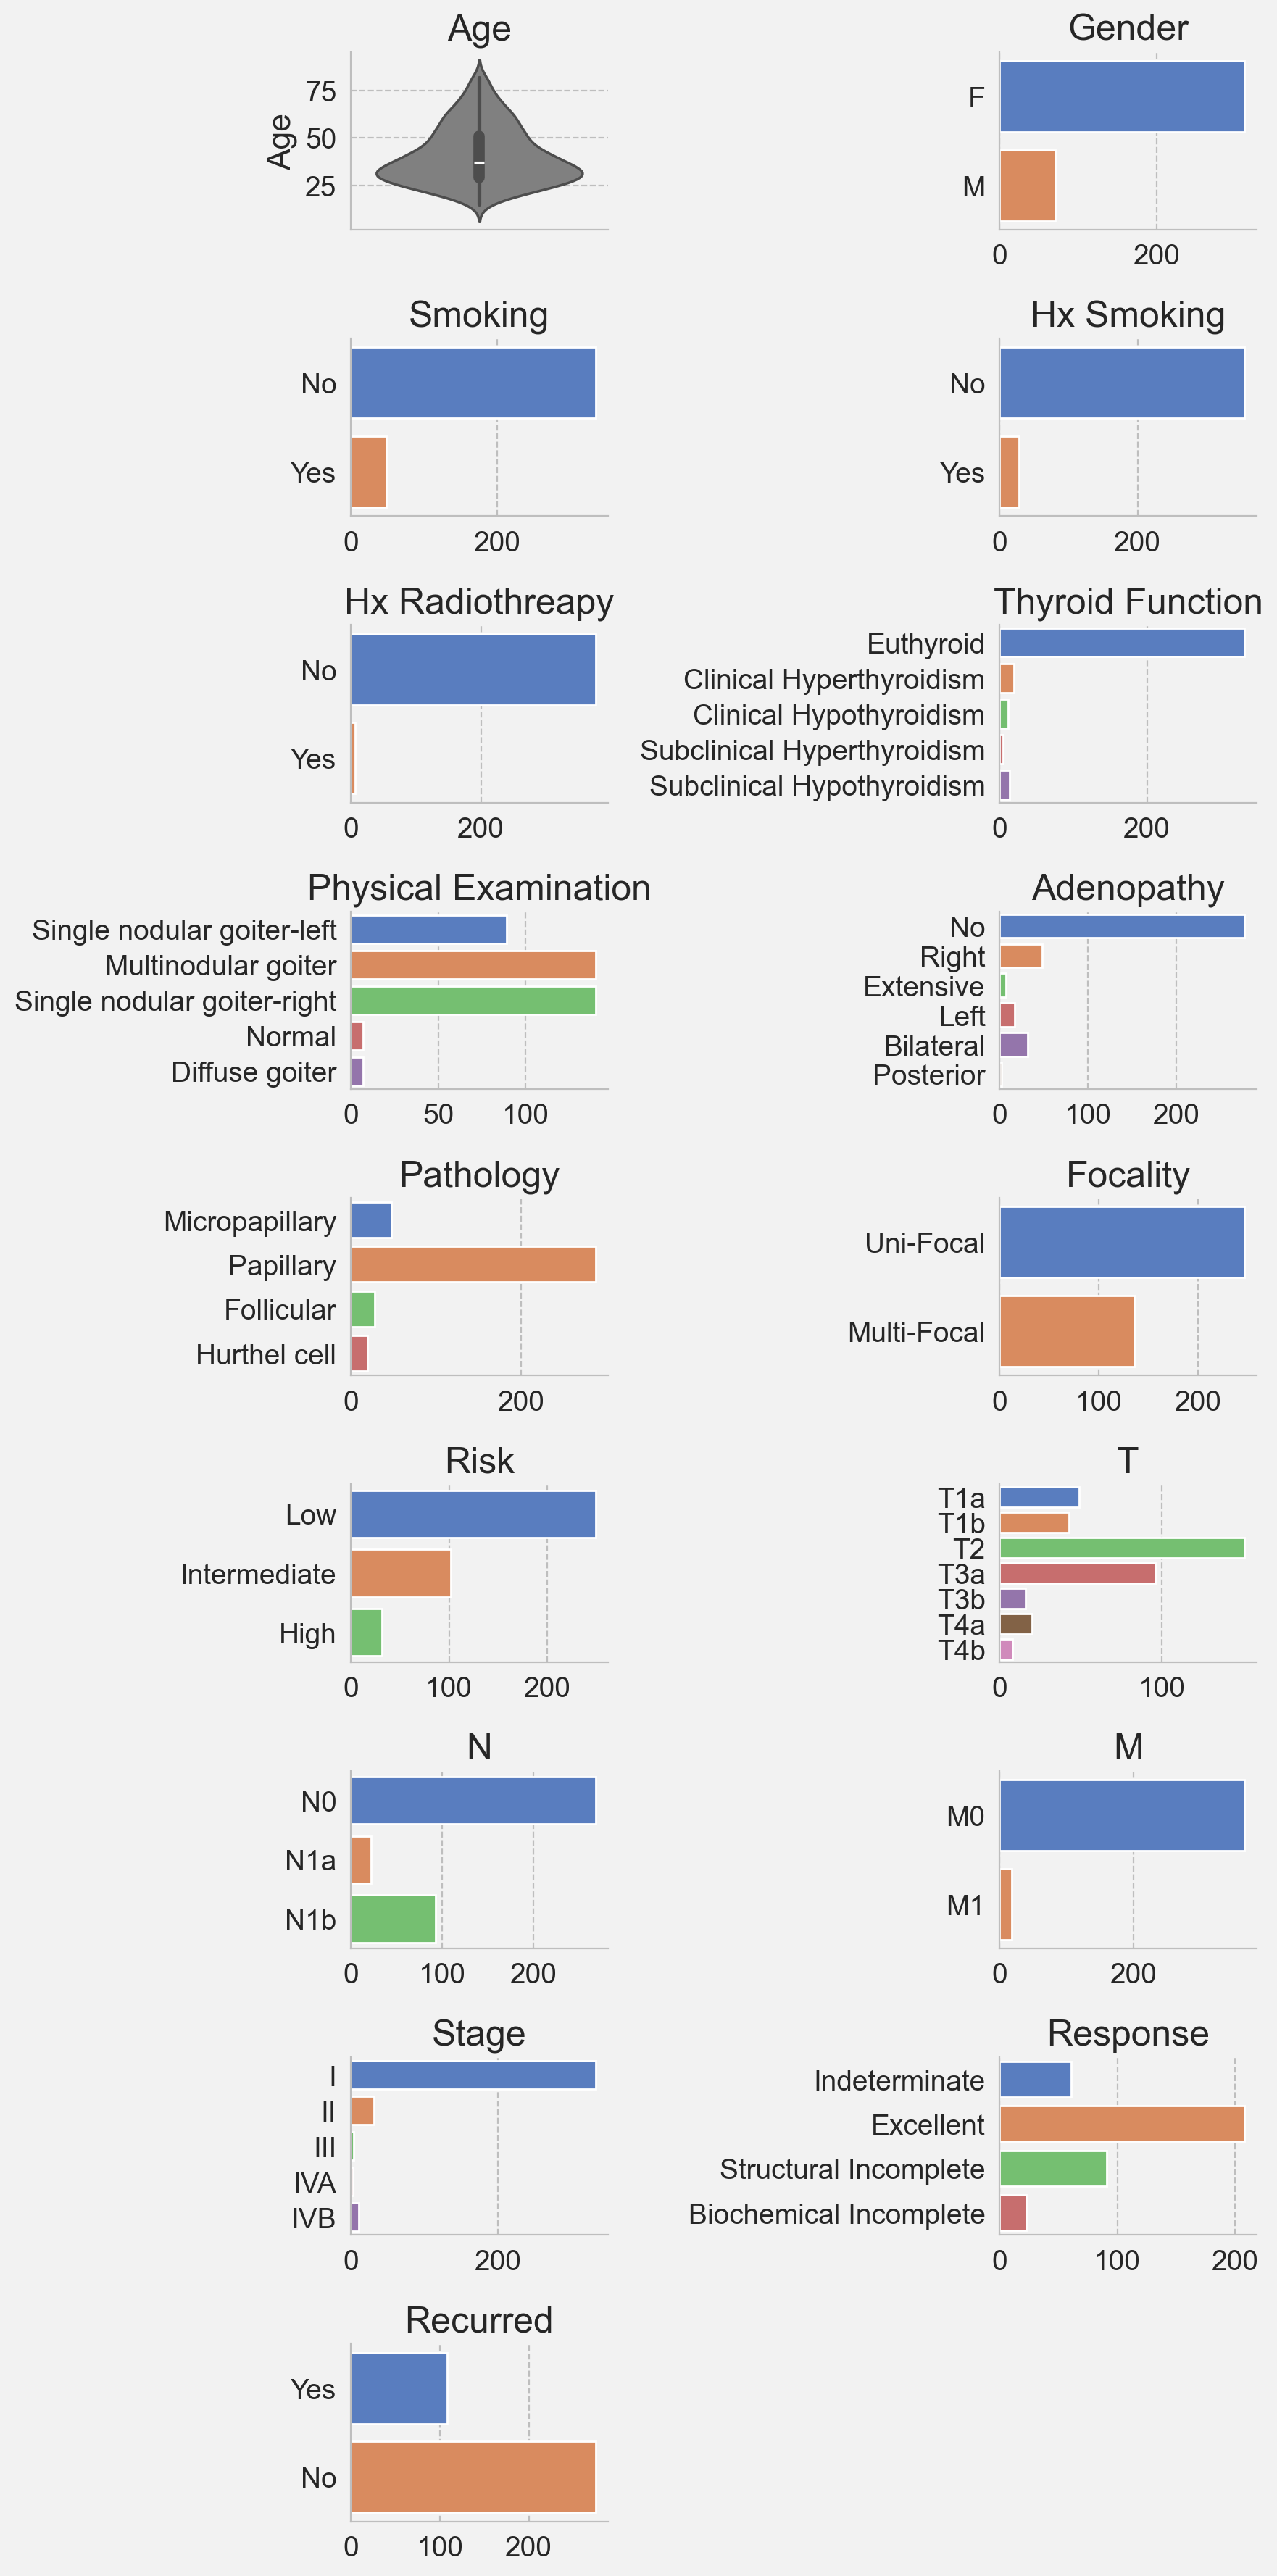

In [6]:


# Detect categorical and numeric columns
categorical_cols = DATA.select_dtypes(include=["object", "category"]).columns
numeric_cols = DATA.select_dtypes(include=["number"]).columns

# Initialize grid layout
n_cols = 2  # Number of columns in the grid
n_rows = int(np.ceil(len(DATA.columns) / n_cols))  # Calculate rows based on number of columns
fig, axes = plt.subplots(n_rows, n_cols, figsize=(9, 2 * n_rows))

# Flatten axes for easy iteration
axes = axes.flatten()

# Loop through each column and create the appropriate plot
for idx, col in enumerate(DATA.columns):
    ax = axes[idx]  # Get the axis to plot on

    # Categorical columns: Bar plots
    if col in categorical_cols:
        sns.countplot(data=DATA, y=col, palette="muted", ax=ax, hue=col)
        ax.set_title(col)
        ax.set_ylabel("")

    # Numeric columns: Violin plots
    elif col in numeric_cols:
        sns.violinplot(data=DATA, y=col, ax=ax, color="grey" )
        ax.set_title(col)

    # Hide x-axis for numeric plots (only used for categorical)
    #if col in numeric_cols:
    ax.set_xlabel("")

# Hide any unused subplots in the grid
for idx in range(len(DATA.columns), len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout and spacing
sns.despine()
plt.tight_layout()
plt.show()

In [7]:
def stratified_plots(data, stratify_col="Recurred"):
    """
    Generate stratified plots for categorical and numeric columns by a specified column.
    Percentage stacked bar plots for categorical features and violin plots for numeric features.
    
    Parameters:
        data (pd.DataFrame): Input DataFrame.
        stratify_col (str): Column name by which to stratify (e.g., "Recurred").
    """
    # Check if the stratify column exists
    if stratify_col not in data.columns:
        raise ValueError(f"{stratify_col} column not found in the dataset.")
    
    # Detect categorical and numeric columns
    categorical_cols = data.select_dtypes(include=["object", "category"]).columns
    numeric_cols = data.select_dtypes(include=["number"]).columns
    
    # Exclude the stratify column from categorical/numeric columns
    categorical_cols = [col for col in categorical_cols if col != stratify_col]
    numeric_cols = [col for col in numeric_cols if col != stratify_col]

    # Combine columns to iterate through all
    all_cols = categorical_cols + numeric_cols
    n_cols = 2  # Number of columns in the grid
    n_rows = int(np.ceil(len(all_cols) / n_cols))  # Calculate rows based on number of columns
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 3 * n_rows))
    
    # Flatten axes for easy iteration
    axes = axes.flatten()
    
    # Loop through each column and create the appropriate plot
    for idx, col in enumerate(all_cols):
        ax = axes[idx]  # Get the axis to plot on
        
        # Categorical columns: Percentage stacked bar plots
        if col in categorical_cols:
            # Calculate percentages
            grouped = data.groupby([stratify_col, col], observed=False).size().unstack(fill_value=0)
            percentages = grouped.div(grouped.sum(axis=1), axis=0) * 100
            percentages.plot(kind="barh", stacked=True, ax=ax,  )
            ax.set_title(col)
            ax.set_ylabel("")
            ax.set_xlabel("")
            # Set x-ticks to 0% and 100% only
            ax.set_xticks([0, 100])
            ax.set_xticklabels(["0%", "100%"])
            ax.grid(axis='y', visible=False)  # Hides horizontal gridlines

            ax.legend(title=col, bbox_to_anchor=(1.05, 1), loc="upper left")

        # Numeric columns: Violin plots
        elif col in numeric_cols:
            if stratify_col == "Recurred":
                hue_order = ["No", "Yes"]
            else:
                hue_order= None
            sns.violinplot(data=data, x=col, y=stratify_col,  order=hue_order,  ax=ax, inner=None, linewidth=1, color="#F2F2F2", cut=1, )
            sns.swarmplot(data=data, x=col, y=stratify_col, order=hue_order,   color='grey', ax=ax, size=2, )

            ax.set_title(col)
            ax.set_ylabel("")
            ax.set_xlabel("")
        
    # Hide any unused subplots in the grid
    for idx in range(len(all_cols), len(axes)):
        fig.delaxes(axes[idx])
    
    # Adjust layout and spacing
    sns.despine()
    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Add space for legends
    plt.show()

stratified_plots(DATA, stratify_col="Recurred")

	Age	Gender	Smoking	Hx Smoking	Hx Radiothreapy	Thyroid Function	Physical Examination	Adenopathy	Pathology	Focality	Risk	T	N	M	Stage	Response	Recurred	Set
330	52	M	Yes	No	No	Euthyroid	Single nodular goiter-left	Right	Follicular	Multi-Focal	Intermediate	T3a	N0	M0	I	Biochemical Incomplete	Yes	Test
301	63	F	No	No	No	Euthyroid	Single nodular goiter-right	No	Follicular	Uni-Focal	Intermediate	T3a	N0	M0	II	Indeterminate	Yes	Test

In [8]:
ORD_FEATURES = ['Stage','N','T','Risk']
CAT_FEATURES  = ['Thyroid Function', 'Physical Examination', 'Adenopathy', 'Pathology','Response',
                    'Gender', 'Smoking', 'Hx Smoking', 'Hx Radiothreapy','M', 'Focality']
NUM_FEATURES = ['Age']

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, MinMaxScaler


In [10]:
y = LabelEncoder().fit_transform( DATA["Recurred"])

In [11]:
X = DATA.drop(columns=["Recurred"])
# Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', NUM_FEATURES),  # skip
        ('ord', OrdinalEncoder(categories=[custom_orders[feature] for feature in ORD_FEATURES]), ORD_FEATURES),   # Apply OrdinalEncoder with custom order
        ('cat', OneHotEncoder(drop='first'), CAT_FEATURES) # Apply OneHotEncoder to categorical features
    ]
)

# Fit and transform the data
X = preprocessor.fit_transform(X)
X = MinMaxScaler().fit_transform(X)
# If you need to wrap the result in a DataFrame, include column names
# Note: OneHotEncoder produces multiple columns per feature
# You might need to extract the feature names from the transformer
X = pd.DataFrame(
    X,
    columns=(
        NUM_FEATURES + ORD_FEATURES + 
        list(preprocessor.named_transformers_['cat'].get_feature_names_out(CAT_FEATURES))
    )
)


In [12]:
# display unique values for each column
for col in X.columns:
    print(f"{col}: {X[col].unique()}")


Age: [0.17910448 0.28358209 0.2238806  0.70149254 0.55223881 0.3880597
 0.46268657 0.53731343 0.37313433 0.89552239 0.65671642 0.50746269
 0.52238806 0.91044776 0.40298507 0.43283582 0.41791045 0.31343284
 0.82089552 0.67164179 0.26865672 0.1641791  0.32835821 0.59701493
 0.23880597 0.44776119 0.07462687 0.34328358 0.20895522 0.14925373
 0.08955224 0.11940299 0.13432836 0.29850746 0.58208955 0.10447761
 0.80597015 0.19402985 0.02985075 0.86567164 0.04477612 0.35820896
 0.62686567 0.76119403 0.25373134 0.47761194 0.6119403  0.71641791
 0.05970149 0.7761194  0.85074627 0.68656716 0.79104478 0.49253731
 0.98507463 0.56716418 0.64179104 0.97014925 0.95522388 0.74626866
 0.         1.         0.8358209  0.73134328 0.94029851]
Stage: [0.   0.25 1.   0.5  0.75]
N: [0.  1.  0.5]
T: [0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.        ]
Risk: [0.  0.5 1. ]
Thyroid Function_Clinical Hypothyroidism: [0. 1.]
Thyroid Function_Euthyroid: [1. 0.]
Thyroid Function_Subclinical 

In [13]:
from sklearn.decomposition import PCA


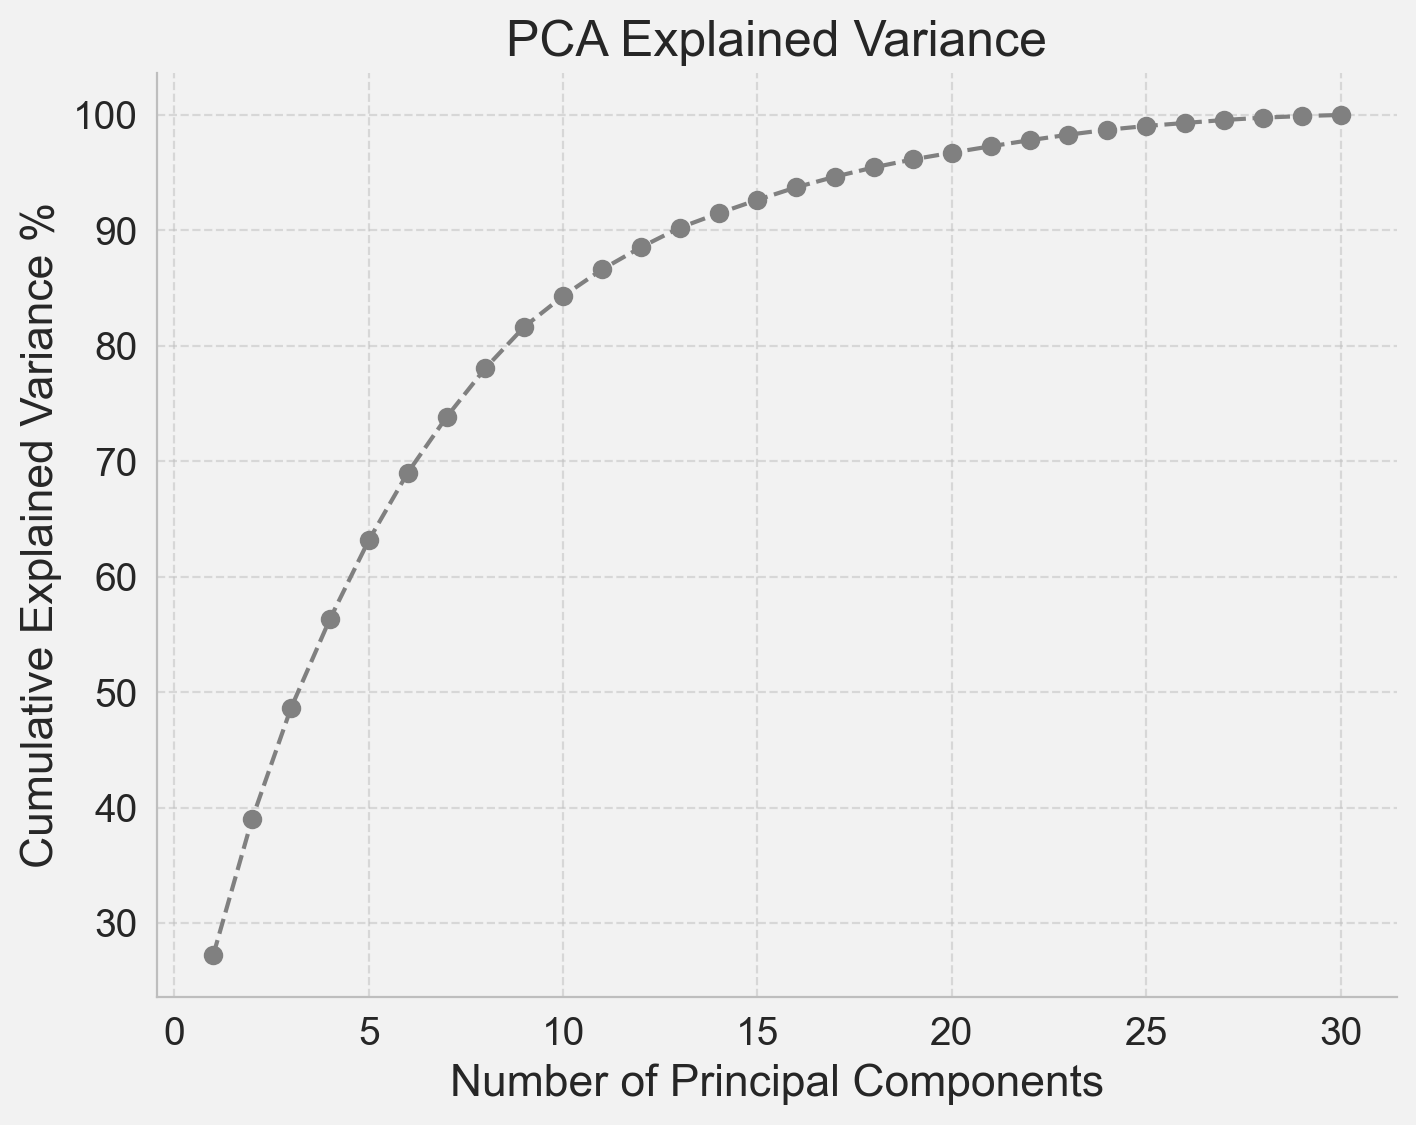

In [14]:
# Perform PCA for all possible components
pca = PCA()
pca.fit(X)  # Fit PCA on X

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_*100

# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)


# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', linestyle='--', color='grey')
plt.title('PCA Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance %')
plt.grid(alpha=0.5)
sns.despine()
plt.show()

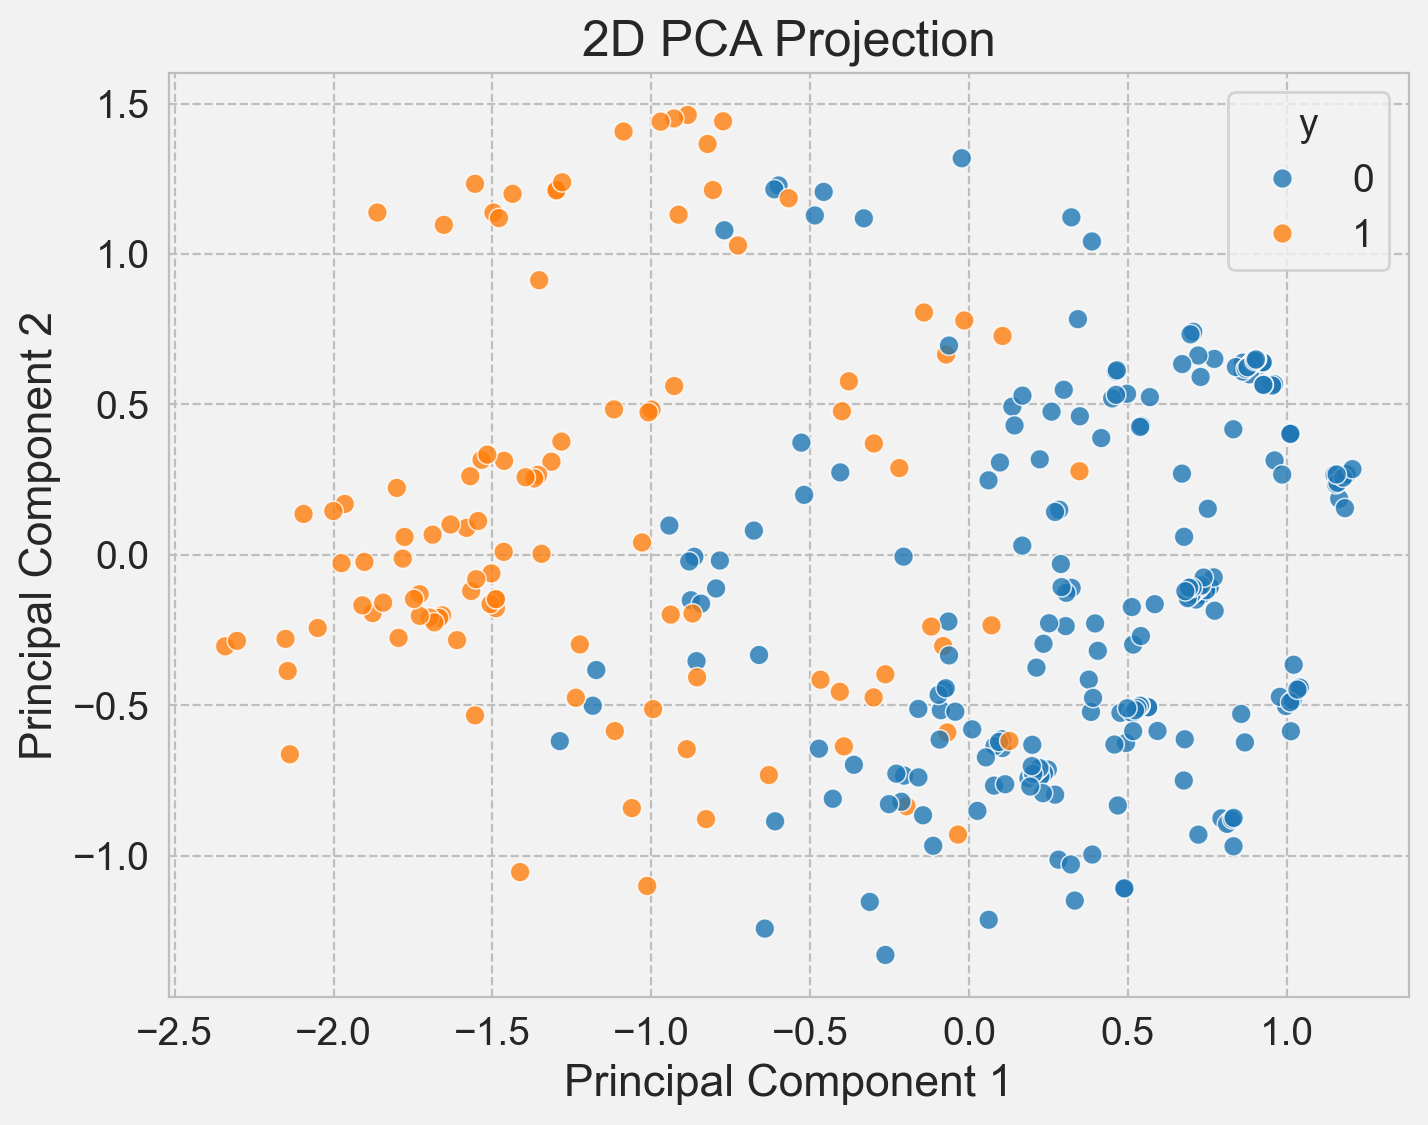

In [15]:
# Assuming X is already preprocessed (transformed) and y is a pandas Series or array-like
pca = PCA(n_components=2)  # Reduce to 2 dimensions
X_pca = pca.fit_transform(X)  # Perform PCA

# Create a DataFrame for easier plotting
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['y'] = y  # Add y as a column for coloring

# Plot using seaborn scatterplot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='y', palette='tab10', s=50, alpha=0.8)
plt.title('2D PCA Projection')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='y')
plt.show()

### UMAP

In [16]:
import umap

# Perform UMAP on X
umap_model = umap.UMAP(n_components=2, random_state=SEED, min_dist=0.1, metric='correlation')
X_umap = umap_model.fit_transform(X)



/Users/marius/miniconda3/envs/DL/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [17]:


# Create a DataFrame for UMAP results and merge with the original DATA
umap_df = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
umap_df = pd.concat([umap_df, DATA], axis=1)  # Combine with original DATA
# Grid of scatterplots
cols = DATA.columns
n_cols = 3  # Number of columns in the grid
n_rows = (len(cols) + n_cols - 1) // n_cols  # Compute rows needed for the grid

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), constrained_layout=True)
axes = axes.flatten()  # Flatten axes array for easy iteration

# Plot each feature
for i, col in enumerate(cols):
    ax = axes[i]
    if col == 'Age':  # Handle numerical feature
        scatter = ax.scatter(umap_df['UMAP1'], umap_df['UMAP2'], c=umap_df[col], cmap='viridis', alpha=0.8)
        fig.colorbar(scatter, ax=ax, label=col)  # Add a colorbar for numerical features
    else:  # Handle categorical features
        sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue=col, palette='tab10', ax=ax, alpha=0.8)
        ax.legend(title=col, loc='best', fontsize='small', frameon=True)

    ax.set_title(f'Colored by {col}')
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.grid(False)

# Hide unused subplots
for j in range(len(cols), len(axes)):
    axes[j].axis('off')
sns.despine()
plt.show()


### Dataset split

80% 20% Training Hold-out

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2, stratify=y)
#Add "Set" column to DATA
DATA['Set'] = 'Test'
DATA.loc[X_train.index, 'Set'] = 'Train'
DATA['Set'].value_counts()

Set
Train    306
Test      77
Name: count, dtype: int64

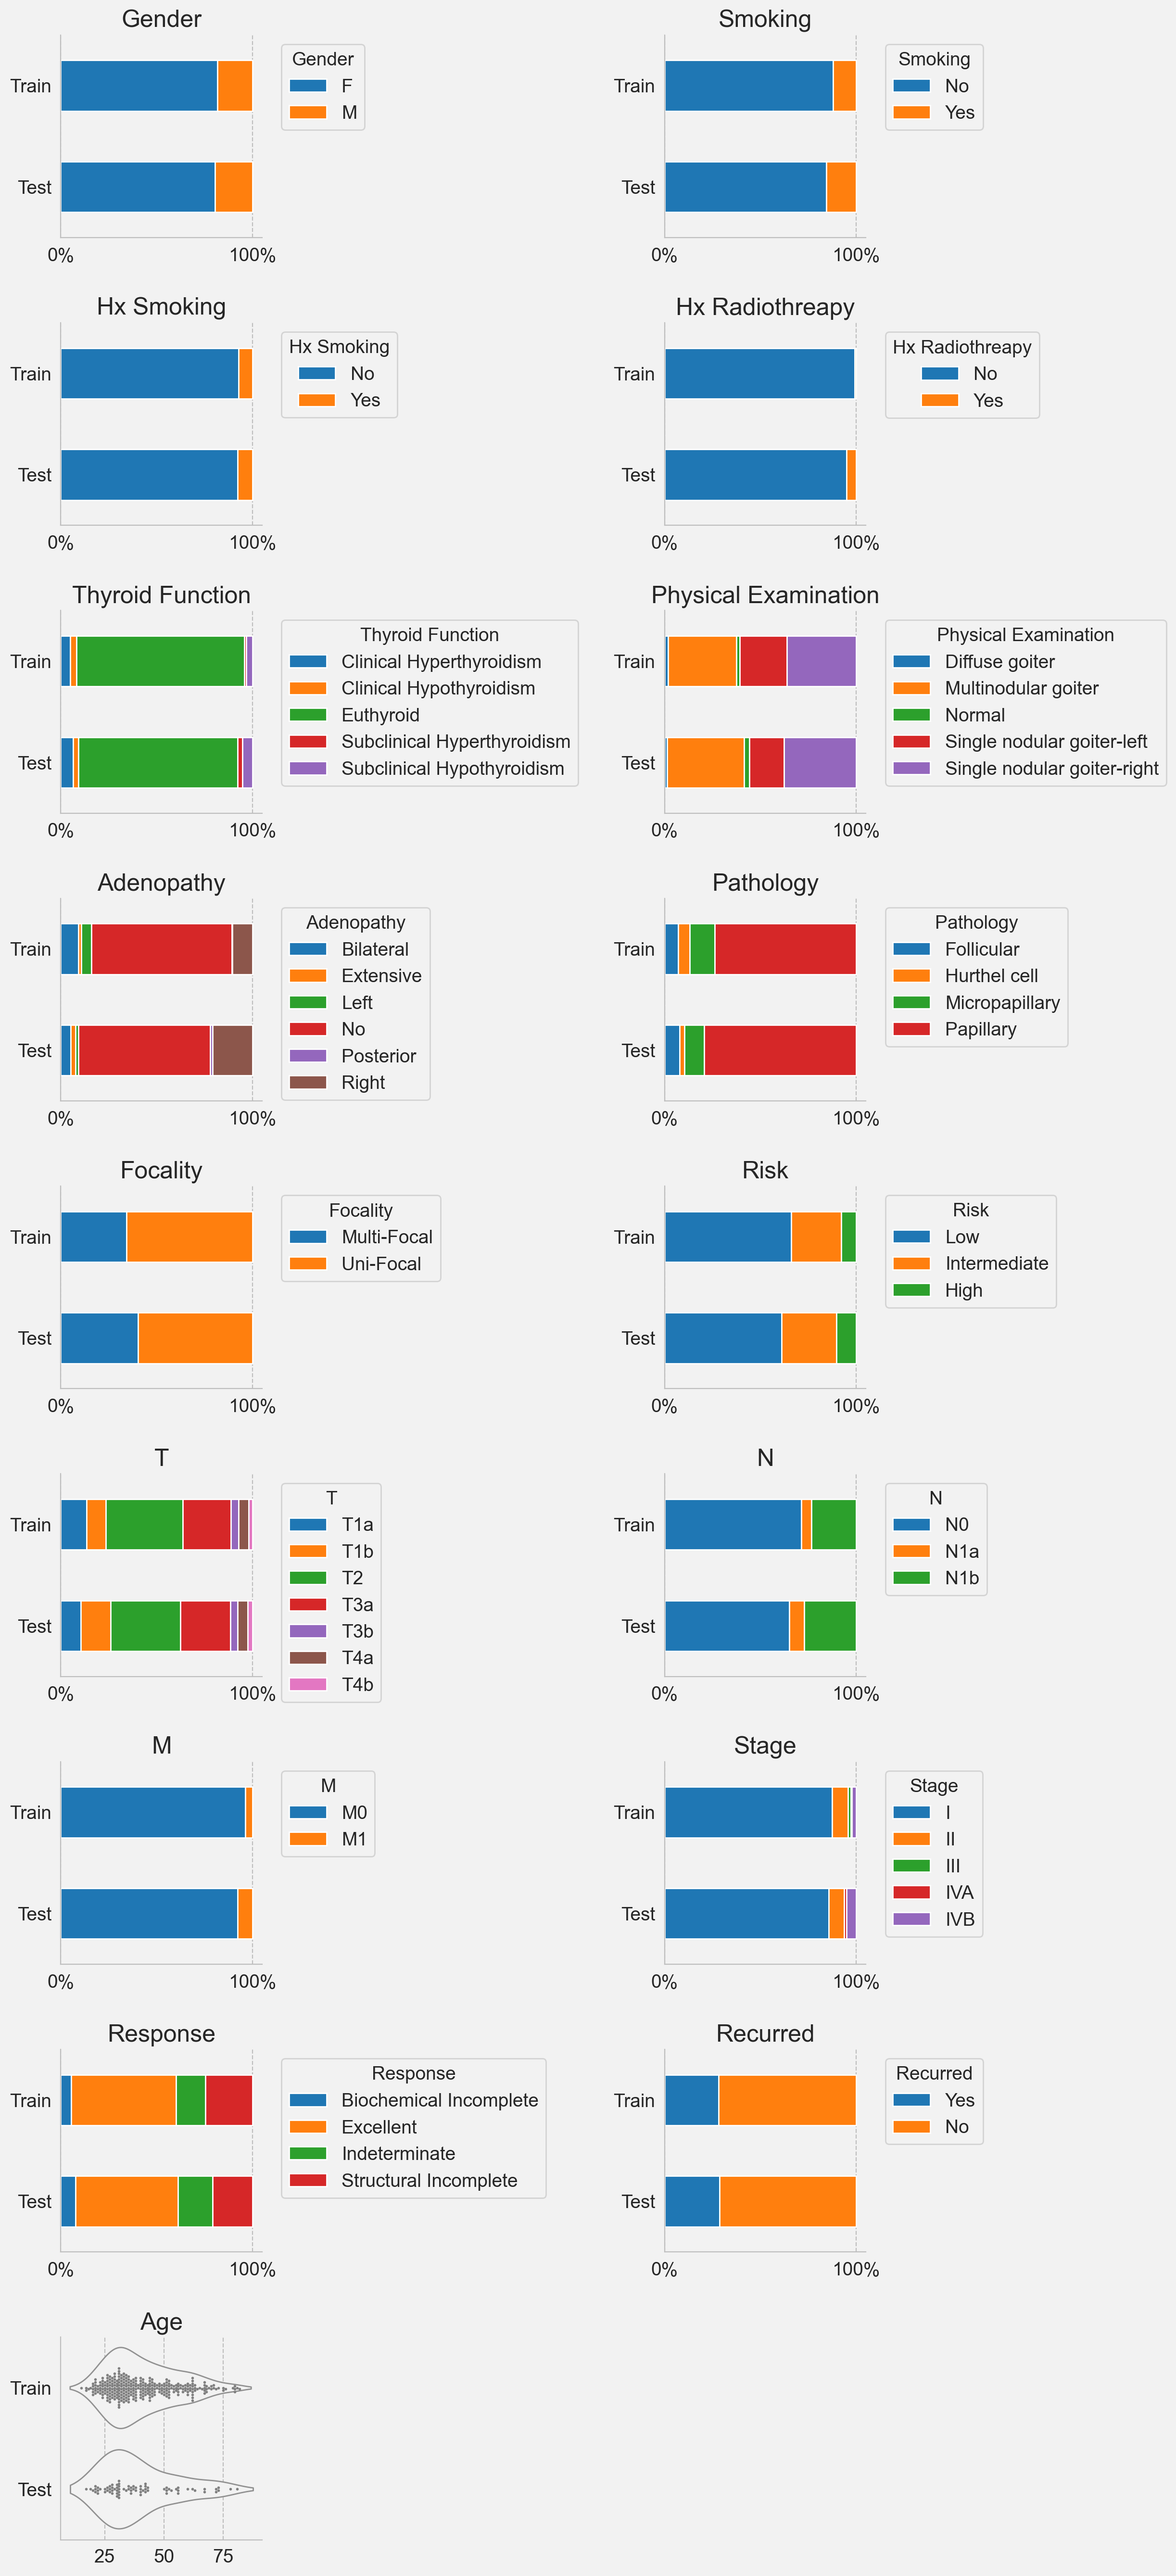

In [47]:
stratified_plots(DATA, stratify_col="Set")

In [48]:

NUM_FEATURES = X.shape[1]
SCALING_FACTORS = [ 0.5, 0.75, 1]
N_HIDDEN_LAYERS = [1, 2, 3, 4, 5]
h_layers_sizes = []

for scaling_factor in SCALING_FACTORS:
    for num_layers in N_HIDDEN_LAYERS:
        hidden_layer_size = []
        for i in range(num_layers):
            tmp = max(int(NUM_FEATURES * scaling_factor ** (i )), 1)
            hidden_layer_size.append(tmp)
        h_layers_sizes.append(hidden_layer_size)

print(h_layers_sizes)


[[30], [30, 15], [30, 15, 7], [30, 15, 7, 3], [30, 15, 7, 3, 1], [30], [30, 22], [30, 22, 16], [30, 22, 16, 12], [30, 22, 16, 12, 9], [30], [30, 30], [30, 30, 30], [30, 30, 30, 30], [30, 30, 30, 30, 30]]


In [22]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, matthews_corrcoef,precision_score,recall_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from scipy.stats import loguniform, uniform, expon
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report


In [50]:
CV_Results = {}
CV_Grids = {}
NUM_TRIALS=1000



#---------------------------------------------------SVC-----------------------------------------------------


CV_Grids['SVC'] = {'model':SVC(class_weight='balanced',random_state=SEED),
                'param_grid':{
                            "C": loguniform(1e-3, 1000),
                            "kernel": ["rbf", "linear", "sigmoid"],
                            "gamma": loguniform(1e-9, 1000),
}}


##--------------------------------------------------RandomForest-------------------------------------------------
CV_Grids['RF'] = {
    'model': RandomForestClassifier(class_weight='balanced', random_state=SEED, bootstrap=True),
    'param_grid': {
        "n_estimators": [20,50,100,200,400],  # List of integers from 10 to 1000, step 50
        "max_depth": np.arange(5, 50, step=1),         # List of integers from 5 to 50, step 5
        "min_samples_split": np.arange(2, 20, step=1), # List of integers from 2 to 20, step 2
        "min_samples_leaf": np.arange(1, 20, step=1),  # List of integers from 1 to 20, step 2
        "criterion": ["gini", "entropy", "log_loss"],
        "max_samples": uniform(0.1,0.9),
    }
}
#--------------------------------------------------LogisticRegression-------------------------------------------------
CV_Grids['LR'] = {
    'model': LogisticRegression(class_weight='balanced', random_state=SEED, max_iter=1000, solver="newton-cholesky"),
    'param_grid': {
        "C": loguniform(1e-4, 1e2),  # Inverse of regularization strength (log-uniform distribution)
        "penalty": ["l2", None],  # Penalty types (no 'none' due to optimization)
        "tol": loguniform(1e-7,1e-3) # l1_ratio only for 'elasticnet' penalty
    }
}
#--------------------------------------------------DT-------------------------------------------------
CV_Grids['DT'] = {
    'model': DecisionTreeClassifier(class_weight='balanced',random_state=SEED,),
    'param_grid': {
        "max_depth": np.arange(5, 50, step=1),         # List of integers from 5 to 50, step 5
        "min_samples_split": np.arange(2, 20, step=1), # List of integers from 2 to 20, step 2
        "min_samples_leaf": np.arange(1, 20, step=1),  # List of integers from 1 to 20, step 2
        "criterion": ["gini", "entropy", "log_loss"]
    }
}
#--------------------------------------------------AdaBoost DT-------------------------------------------------
CV_Grids['AdaBoost'] = {
    'model': AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',random_state=SEED,), algorithm='SAMME', random_state=SEED),
    'param_grid': {
        "n_estimators": [20,50,100,200,400],  # List of integers from 10 to 1000, step 50
        "learning_rate": loguniform(1e-5,10),
        "estimator__max_depth": np.arange(5, 50, step=1),         # List of integers from 5 to 50, step 5
        "estimator__min_samples_split": np.arange(2, 20, step=1), # List of integers from 2 to 20, step 2
        "estimator__min_samples_leaf": np.arange(1, 20, step=1),  # List of integers from 1 to 20, step 2
        "estimator__criterion": ["gini", "entropy", "log_loss"]
    }
}

#--------------------------------------------------XGBoost DT-------------------------------------------------
CV_Grids['XGBoost'] = {
    'model': XGBClassifier(random_state=SEED),
    'param_grid': {
        "n_estimators": [20,50,100,200,400],  # List of integers from 10 to 1000, step 50
        "learning_rate": loguniform(1e-5,10),
        "max_depth": np.arange(5, 50, step=1),         # List of integers from 5 to 50, step 5
        "subsample": uniform(0.1,0.9), 
        "colsample_bytree": uniform(0.5, 0.5), 
        "colsample_bynode": uniform(0.5, 0.5), 
        "colsample_bylevel": uniform(0.5, 0.5), 

    }
}
#--------------------------------------------------MLP-------------------------------------------------


CV_Grids['MLP'] = {
    'model': MLPClassifier(random_state=SEED, 
                    solver='adam', max_iter=500, learning_rate='adaptive', learning_rate_init=0.05 ),
    'param_grid': {
        "hidden_layer_sizes": h_layers_sizes,  # List of integers from 10 to 1000, step 50
        "activation": [ "logistic",  "relu", "tanh"],
        "batch_size": [4,8,16,32,64],
        "alpha": loguniform(1e-5,1),
    }
}

#


#--------------------------------------------------Nested Cross Validation-------------------------------------------------
for model_name, model_dict in CV_Grids.items():
    print(f"Running RandomizedSearchCV for {model_name}...")
    RandomSearch = RandomizedSearchCV(
        estimator=model_dict['model'],
        param_distributions=model_dict['param_grid'],
        #scoring= ['matthews_corrcoef','precision','recall'],  # Optimize MCC
        scoring= 'matthews_corrcoef',  # Optimize MCC
        n_iter=NUM_TRIALS,            # Max trials
        cv=5,                # Stratified 5-fold CV
        verbose=1,
        random_state=SEED,
        n_jobs=-1
    )
    RandomSearch.fit(X_train, y_train)
    CV_Results[model_name] = {'data':RandomSearch.cv_results_, 
                            'best_model':RandomSearch.best_estimator_}

    
    # Best results
    print(f"{model_name} Best Params:", RandomSearch.best_params_)
    print(f"{model_name} Best MCC:", RandomSearch.best_score_)
    print()



Running RandomizedSearchCV for SVC...
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
SVC Best Params: {'C': 80.12842747582903, 'gamma': 0.0002678054520367629, 'kernel': 'sigmoid'}
SVC Best MCC: 0.9120972544815678

Running RandomizedSearchCV for RF...
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
RF Best Params: {'criterion': 'log_loss', 'max_depth': 26, 'max_samples': 0.6237742617229589, 'min_samples_leaf': 2, 'min_samples_split': 9, 'n_estimators': 100}
RF Best MCC: 0.9053206555520148

Running RandomizedSearchCV for LR...
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


/Users/marius/miniconda3/envs/DL/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marius/miniconda3/envs/DL/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marius/miniconda3/envs/DL/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marius/miniconda3/envs/DL/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marius/miniconda3/envs/DL/lib/python3.10/site-packages/sklearn/linear_model/_glm/_newton_solver.py:497: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hess

LR Best Params: {'C': 3.6422282566934276, 'penalty': 'l2', 'tol': 7.810247638385702e-06}
LR Best MCC: 0.881795525434607

Running RandomizedSearchCV for DT...
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
DT Best Params: {'min_samples_split': 9, 'min_samples_leaf': 3, 'max_depth': 34, 'criterion': 'gini'}
DT Best MCC: 0.8827496918364313

Running RandomizedSearchCV for AdaBoost...
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
AdaBoost Best Params: {'estimator__criterion': 'gini', 'estimator__max_depth': 41, 'estimator__min_samples_leaf': 8, 'estimator__min_samples_split': 11, 'learning_rate': 0.42411146326433163, 'n_estimators': 50}
AdaBoost Best MCC: 0.9197161823789249

Running RandomizedSearchCV for XGBoost...
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
XGBoost Best Params: {'colsample_bylevel': 0.8016097051066862, 'colsample_bynode': 0.6686135663777102, 'colsample_bytree': 0.9527623961648369, 'learning_rate': 0.432251356337188

/Users/marius/miniconda3/envs/DL/lib/python3.10/site-packages/sklearn/model_selection/_search.py:412: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(param_list)


In [20]:

# Define the discrete hyperparameter grids
CV_Results = {}
CV_Grids = {}
SEED = 42


#---------------------------------------------------SVC-----------------------------------------------------
CV_Grids['SVC'] = {
    'model': SVC(class_weight='balanced',random_state=SEED),
    'param_grid': {
        "C": np.logspace(-3, +3, 10).tolist(),
        "kernel": ["rbf", "linear", "sigmoid"],
        "gamma": np.logspace(-9, +3, 10).tolist(),
    }
}

#--------------------------------------------------RandomForest-------------------------------------------------
CV_Grids['RF'] = {
    'model': RandomForestClassifier(class_weight='balanced', random_state=SEED, bootstrap=True),
    'param_grid': {
        "n_estimators": [20, 50, 100, 200, 400],
        "max_depth": list(range(5, 50, 5)),
        "min_samples_split": list(range(2, 20, 4)),
        "criterion": ["gini", "entropy", "log_loss"],
        "max_samples": np.linspace(0.1, 1.0, 10).tolist(),
    }
}

#--------------------------------------------------LogisticRegression-------------------------------------------------
CV_Grids['LR'] = {
    'model': LogisticRegression(class_weight='balanced', random_state=SEED, max_iter=1000, solver='newton-cholesky'),
    'param_grid': {
        "C": np.logspace(-4, +2, 10).tolist(),
        "penalty": ["l2", None],
        "tol": np.logspace(-7, -3, 10).tolist(),
    }
}

#--------------------------------------------------DT-------------------------------------------------
CV_Grids['DT'] = {
    'model': DecisionTreeClassifier(class_weight='balanced',random_state=SEED),
    'param_grid': {
        "max_depth": list(range(5, 50, 5)),
        "min_samples_split": list(range(2, 20, 4)),
        "criterion": ["gini", "entropy", "log_loss"],
    }
}

#--------------------------------------------------AdaBoost DT-------------------------------------------------
CV_Grids['AdaBoost'] = {
    'model': AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',random_state=SEED,), algorithm='SAMME', random_state=SEED),
    'param_grid': {
        "n_estimators": [20, 50, 100, 200, 400],
        "learning_rate": np.logspace(-5, +1, 10).tolist(),
        "estimator__max_depth": list(range(5, 50, 5)),
        "estimator__min_samples_split": list(range(2, 20, 4)),
        "estimator__criterion": ["gini", "entropy", "log_loss"],
    }
}

#--------------------------------------------------XGBoost DT-------------------------------------------------
CV_Grids['XGBoost'] = {
    'model': XGBClassifier(random_state=SEED),
    'param_grid': {
        "n_estimators": [20, 50, 100, 200, 400],
        "learning_rate": np.logspace(-5, +1, 6).tolist(),
        "max_depth": list(range(5, 50, 5)),
        "subsample": np.linspace(0.1, 1.0, 6).tolist()
    }
}

#--------------------------------------------------MLP-------------------------------------------------
CV_Grids['MLP'] = {
    'model': MLPClassifier(random_state=SEED, 
                    solver='adam', max_iter=500, learning_rate='adaptive', learning_rate_init=0.05 ),
    'param_grid': {
        "hidden_layer_sizes": [[10], [50], [100], [500], [1000]],
        "activation": ["logistic", "relu", "tanh"],
        "batch_size": [4, 8, 16, 32, 64],
        "alpha": np.logspace(-5, 0, 10).tolist(),
    }
}

# Print results
import pprint
pprint.pprint(CV_Grids)

#--------------------------------------------------Nested Cross Validation-------------------------------------------------
Testing_Results = {}
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for model_name, model_dict in CV_Grids.items():
    Testing_Results[model_name] = {
        'precision': list(),
        'recall': list(),
        'f1': list(),
        'mcc': list(),
        'best_params':list()
    }
    for train_ix, test_ix in cv_outer.split(X):
        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]
        # configure the cross-validation procedure
        cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
        # define search
        search = GridSearchCV(model_dict['model'] , model_dict['param_grid'], scoring='matthews_corrcoef', cv=cv_inner, refit=True)
        # execute search
        result = search.fit(X_train, y_train)
        # get the best performing model fit on the whole training set
        best_model = result.best_estimator_
        # evaluate model on the hold out dataset
        y_pred = best_model.predict(X_test)
        # evaluate the model
        Testing_Results[model_name]['precision'].append(precision_score(y_test, y_pred))
        Testing_Results[model_name]['recall'].append(recall_score(y_test, y_pred))
        Testing_Results[model_name]['f1'].append(f1_score(y_test, y_pred))
        Testing_Results[model_name]['mcc'].append(matthews_corrcoef(y_test, y_pred))
        Testing_Results[model_name]['best_params'].append(result.best_params_)
    mean_MCC = np.mean(Testing_Results[model_name]['mcc'])
    st_MCC = np.std(Testing_Results[model_name]['mcc'])
    print(f'{model_name}: {mean_MCC} +- {st_MCC}')




# Predict on the test set
for model_name, model in BEST_MODELS:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    Testing_Results[model_name] = {
        'precision_test': precision_score(y_test, y_pred),
        'recall_test': recall_score(y_test, y_pred),
        'f1_test': f1_score(y_test, y_pred),
        'mcc_test': matthews_corrcoef(y_test, y_pred),
        'y_pred': y_pred
    }

{'AdaBoost': {'model': AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    random_state=42),
                   random_state=42),
              'param_grid': {'estimator__criterion': ['gini',
                                                      'entropy',
                                                      'log_loss'],
                             'estimator__max_depth': [5,
                                                      10,
                                                      15,
                                                      20,
                                                      25,
                                                      30,
                                                      35,
                                                      40,
                                                      45],
                             'estimator

##### Import CV_results if exist else save it

In [51]:
import os
import pickle

# File name
filename = "CV_Results.pkl"

# Import flag
import_existing = False # Set to True to import if file exists, False to overwrite

if import_existing and os.path.exists(filename):
    with open(filename, 'rb') as f:
        CV_Results = pickle.load(f)
        print(f"Imported results from '{filename}'.")
        print("Imported Results:", CV_Results)  # Print the imported results
elif os.path.exists(filename): # file exists but import_existing is false
    with open(filename, 'wb') as f:
        pickle.dump(CV_Results, f)
        print(f"File '{filename}' overwritten with new CV_Results.")
else:
    with open(filename, 'wb') as f:
        pickle.dump(CV_Results, f)
        print(f"Dictionary saved to '{filename}'.")


File 'CV_Results.pkl' overwritten with new CV_Results.


In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np




In [53]:
from sklearn.ensemble import StackingClassifier
BEST_MODELS = []
for model_name, cv_result in CV_Results.items():
    BEST_MODELS.append( (model_name, cv_result['best_model']) )


In [54]:
from sklearn.model_selection import StratifiedKFold

STACKED = StackingClassifier(estimators=BEST_MODELS, 
                                final_estimator=MLPClassifier(random_state=SEED, 
                                                                solver='adam', max_iter=500, 
                                                                learning_rate='adaptive', learning_rate_init=0.05 ),
                                cv=StratifiedKFold(n_splits=5),
                                n_jobs=-1,  )

STACKED

StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimators=[('SVC',
                                SVC(C=80.12842747582903,
                                    class_weight='balanced',
                                    gamma=0.0002678054520367629,
                                    kernel='sigmoid', random_state=42)),
                               ('RF',
                                RandomForestClassifier(class_weight='balanced',
                                                       criterion='log_loss',
                                                       max_depth=26,
                                                       max_samples=0.6237742617229589,
                                                       min_samples_leaf=2,
                                                       m...
                                              num_parallel_tree=None,
                                              random_state=42, ...)),
                               ('MLP',
                                MLPClassifier(activation='tanh',
                                              alpha=0.22921429142374816,
                                              batch_size=8,
                                              hidden_layer_sizes=[30, 22, 16,
                                                                  12, 9],
                                              learning_rate='adaptive',
                                              learning_rate_init=0.05,
                                              max_iter=500, random_state=42))],
                   final_estimator=MLPClassifier(learning_rate='adaptive',
                                                 learning_rate_init=0.05,
                                                 max_iter=500,
                                                 random_state=42),
                   n_jobs=-1)

In [55]:

STACKED_params = {
        "passthrough": [True, False],
        "final_estimator__hidden_layer_sizes": h_layers_sizes,  # List of integers from 10 to 1000, step 50
        "final_estimator__activation": [ "logistic",  "relu", "tanh"],
        "final_estimator__batch_size": [4,8,16,32,64],
        "final_estimator__alpha": loguniform(1e-5,1),
    }




RandomSearch = RandomizedSearchCV(
        estimator=STACKED,
        param_distributions=STACKED_params,
        scoring= 'matthews_corrcoef',  # Optimize MCC
        n_iter=10,            # Max trials
        cv=5,                # Stratified 5-fold CV
        verbose=1,
        random_state=SEED,
        n_jobs=-1
    )
RandomSearch.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", RandomSearch.best_params_)
print("Best score:", RandomSearch.best_score_)

STACKED = RandomSearch.best_estimator_


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/marius/miniconda3/envs/DL/lib/python3.10/site-packages/sklearn/model_selection/_search.py:412: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(param_list)


Best parameters: {'final_estimator__activation': 'tanh', 'final_estimator__alpha': 0.21423021757741043, 'final_estimator__batch_size': 32, 'final_estimator__hidden_layer_sizes': [30, 22, 16], 'passthrough': False}
Best score: 0.9276392955329756


In [56]:
CV_Results['Stacking'] = {'data':RandomSearch.cv_results_, 
                            'best_model':RandomSearch.best_estimator_}

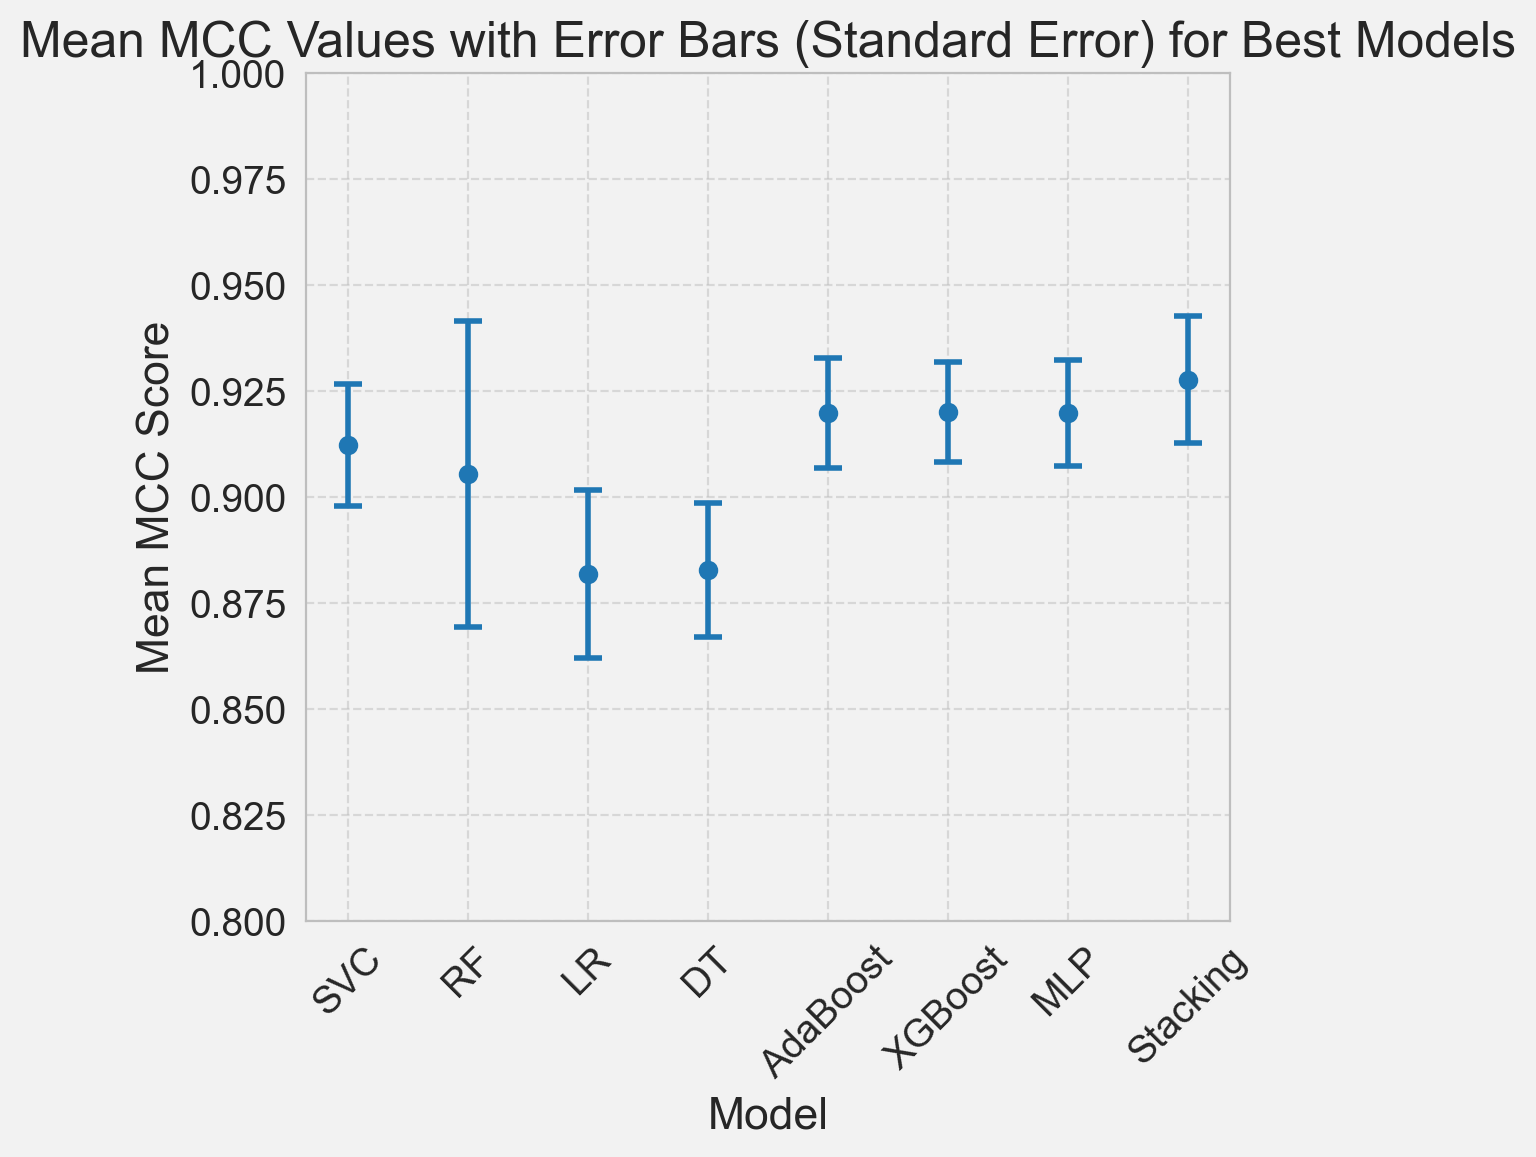

In [57]:
BEST_MODELS.append(('Stacking', CV_Results['Stacking']['best_model']))

# Initialize a DataFrame to hold the results
CV_Scores = []

# Collect MCC scores of the best models for each model name
for model_name, cv_result in CV_Results.items():
    # Get the best index (the one corresponding to the best mean MCC)
    best_index = cv_result['data']['rank_test_score'].argmin()
    
    # Extract MCC scores for the best model's splits
    fold_scores = [cv_result['data'][f'split{fold_idx}_test_score'][best_index] for fold_idx in range(5)]
    
    # Calculate the mean and standard error
    mean_mcc = np.mean(fold_scores)
    std_error_mcc = np.std(fold_scores, ddof=1) / np.sqrt(len(fold_scores))  # Standard error
    
    # Store the model name, mean MCC, and standard error
    CV_Scores.append({'Model': model_name, 'Mean MCC': mean_mcc, 'SE MCC': std_error_mcc})

# Convert to a DataFrame for easier plotting
CV_Scores = pd.DataFrame(CV_Scores)

# Plot the mean MCC values with error bars
plt.figure(figsize=(6, 6))
plt.errorbar(
    x=CV_Scores['Model'], 
    y=CV_Scores['Mean MCC'], 
    yerr=CV_Scores['SE MCC'], 
    fmt='o',                # Circle marker for the means
    #color='dodgerblue',     # Marker color
    #ecolor='red',           # Error bar color
    elinewidth=2,           # Error bar thickness
    capsize=5,              # Add caps at the ends of error bars
    capthick=2              # Cap thickness
)

# Customizing the plot
plt.title("Mean MCC Values with Error Bars (Standard Error) for Best Models")
plt.ylabel("Mean MCC Score")
plt.xlabel("Model")
plt.xticks(rotation=45)  # Rotate model names for better readability
plt.ylim(0.8,1)
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.tight_layout()
plt.show()

In [58]:

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
Testing_Results = {}

# Predict on the test set
for model_name, model in BEST_MODELS:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    Testing_Results[model_name] = {
        'precision_test': precision_score(y_test, y_pred),
        'recall_test': recall_score(y_test, y_pred),
        'f1_test': f1_score(y_test, y_pred),
        'mcc_test': matthews_corrcoef(y_test, y_pred),
        'y_pred': y_pred
    }

/Users/marius/miniconda3/envs/DL/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [59]:
CLASS_DICT = {0:'Not R', 1:'R'}

In [60]:
# testing all the best models
def my_classification_report(y_true, y_pred, TITLE):
    """
    Generate a classification report including confusion matrix, normalized confusion matrix, and metrics.

    Parameters:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        TITLE (str): Title for the plot.

    Returns:
        plot
        pandas.DataFrame: Results of the classification report.
    """
    labels = list(CLASS_DICT.keys())
    class_names = list(CLASS_DICT.values())
    
    cm = pd.DataFrame(data=confusion_matrix(y_true, y_pred, labels=labels),
                        index=class_names, columns=[f'{name}' for name in class_names])
    cm_normalized = cm.divide(cm.sum(axis=1), axis=0)
    cm_df = pd.DataFrame(data=cm_normalized, index=class_names, columns=[f'{name}' for name in class_names])

    plt.figure(figsize=(6, 3))
    plt.suptitle(f'{TITLE}', fontsize=20, y=1.02)

    # Plot confusion matrix counts
    plt.subplot(1, 2, 1)
    plt.title('Counts', fontsize=16)
    sns.heatmap(cm, annot=True, fmt="d", square=1, linewidths=3, cmap='bone_r', cbar=0, annot_kws={"fontsize": 14})
    #plt.xticks(rotation=45)  
    plt.yticks(rotation=0)  
    plt.ylabel('True label')
    
    # Plot normalized confusion matrix
    plt.subplot(1, 2, 2)
    plt.title('Percentage by class', fontsize=16)
    sns.heatmap(cm_df, annot=True, fmt=".0%", square=1, linewidths=3, cmap='bone_r', annot_kws={"fontsize": 14}, cbar=0)
    #plt.xticks(rotation=45)  
    plt.yticks(rotation=0)  
    plt.ylabel('')
    plt.xlabel('')
    plt.yticks([])
    
    plt.tight_layout()
    plt.show()


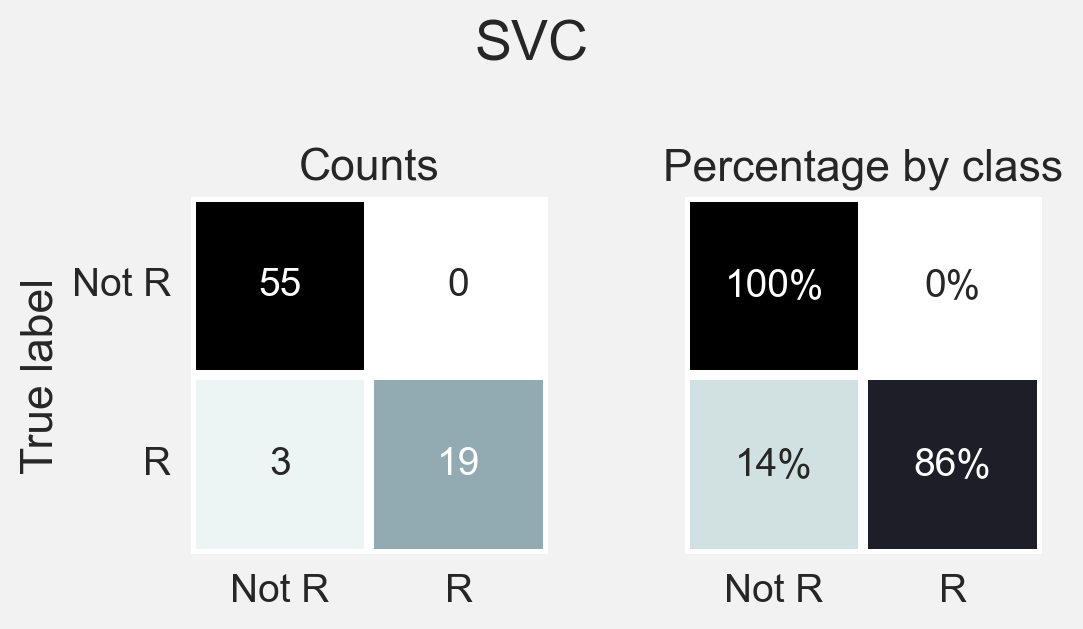

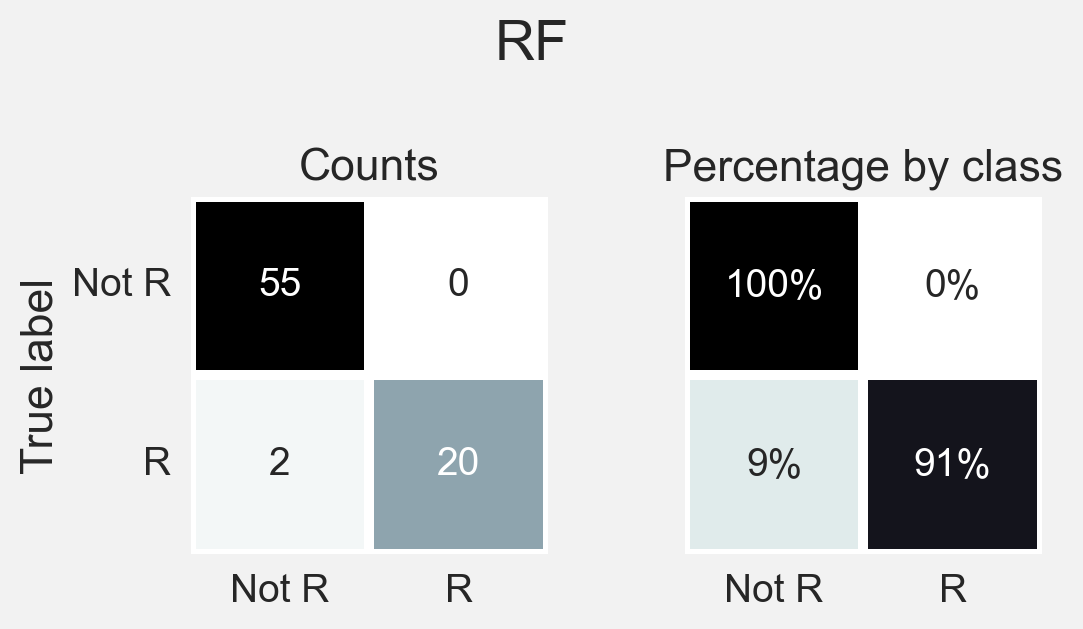

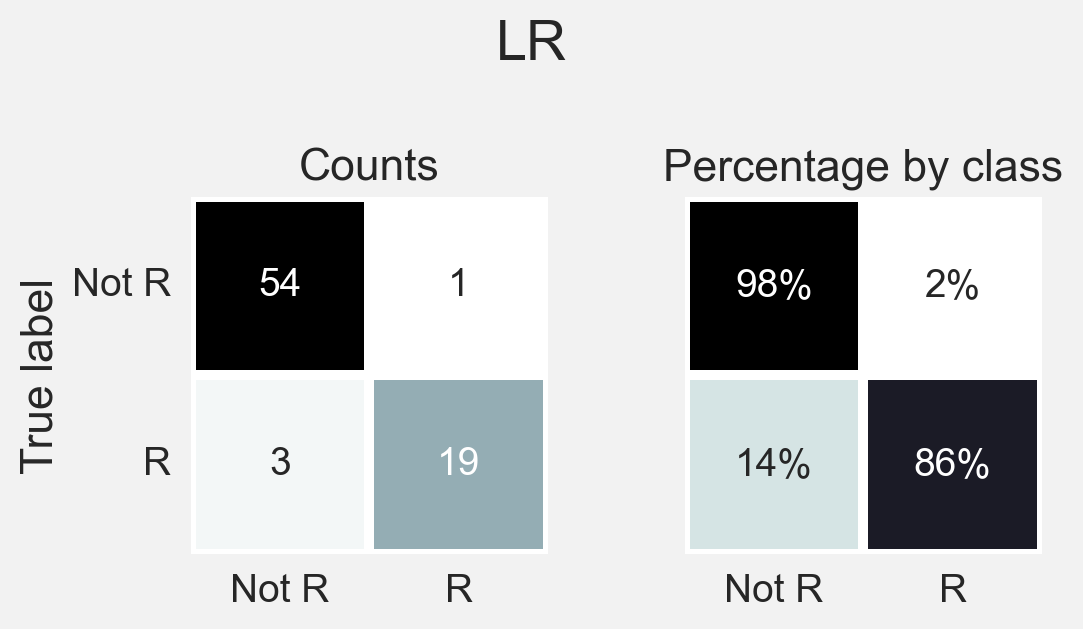

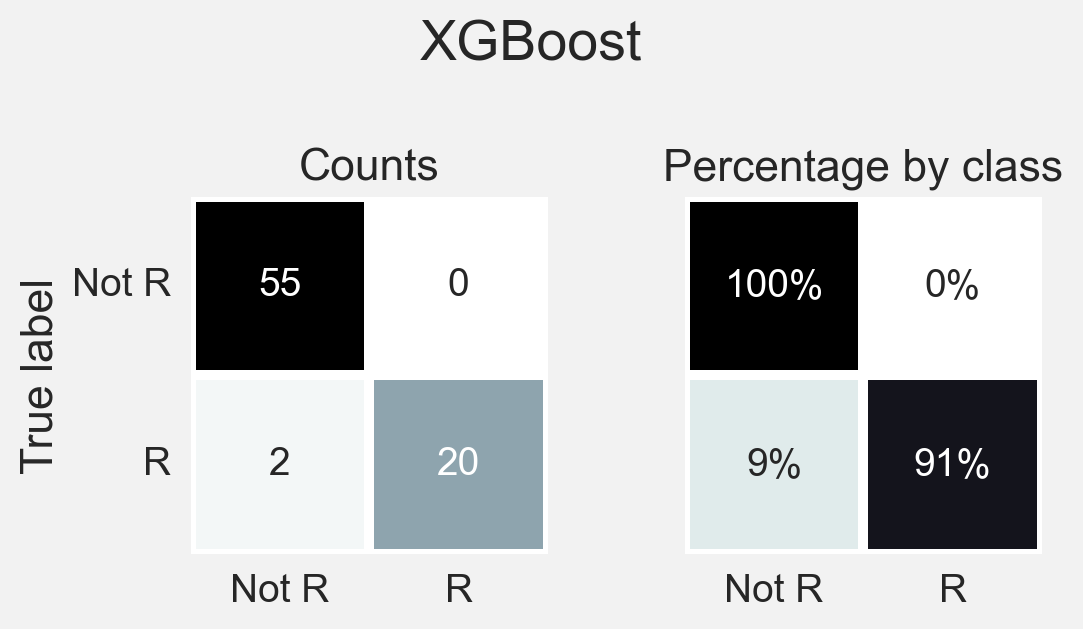

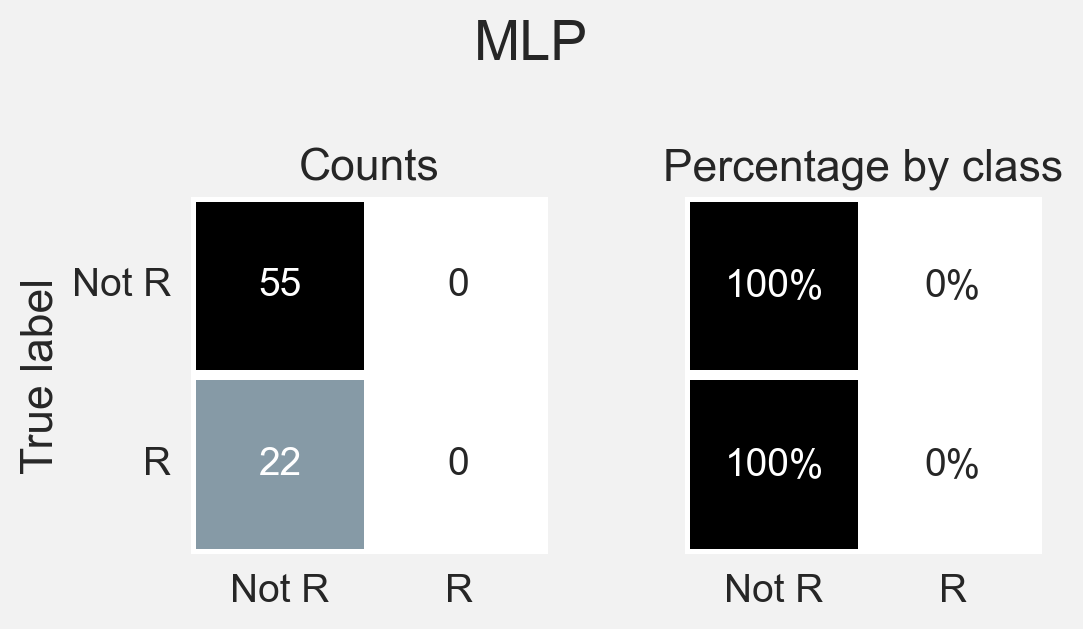

In [61]:
for model_name, model in BEST_MODELS:
    y_pred = Testing_Results[model_name]['y_pred']
    my_classification_report(y_test, y_pred, model_name)

In [62]:
CV_Scores

Model  Mean MCC    SE MCC
0       SVC  0.912097  0.014392
1        RF  0.905321  0.036062
2        LR  0.881796  0.019787
3        DT  0.882750  0.015808
4  AdaBoost  0.919716  0.012929
5   XGBoost  0.920052  0.011761
6       MLP  0.919815  0.012469
7  Stacking  0.927639  0.014985

In [63]:
# barplot with models on x and mc on y
# Create a DataFrame from the Testing_Results dictionary
Testing_scores = pd.DataFrame(Testing_Results).T
Testing_scores.reset_index(inplace=True, names='Model')
Testing_scores


Model precision_test recall_test   f1_test  mcc_test  \
0       SVC            1.0    0.863636  0.926829  0.904967   
1        RF            1.0    0.909091  0.952381  0.936586   
2        LR           0.95    0.863636  0.904762  0.871025   
3        DT       0.740741    0.909091  0.816327   0.74017   
4  AdaBoost            1.0    0.863636  0.926829  0.904967   
5   XGBoost            1.0    0.909091  0.952381  0.936586   
6       MLP            0.0         0.0       0.0       0.0   
7  Stacking            1.0    0.909091  0.952381  0.936586   

                                              y_pred  
0  [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, ...  
1  [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...  
2  [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, ...  
3  [1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...  
4  [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...  
5  [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...  
6  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
7  [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...

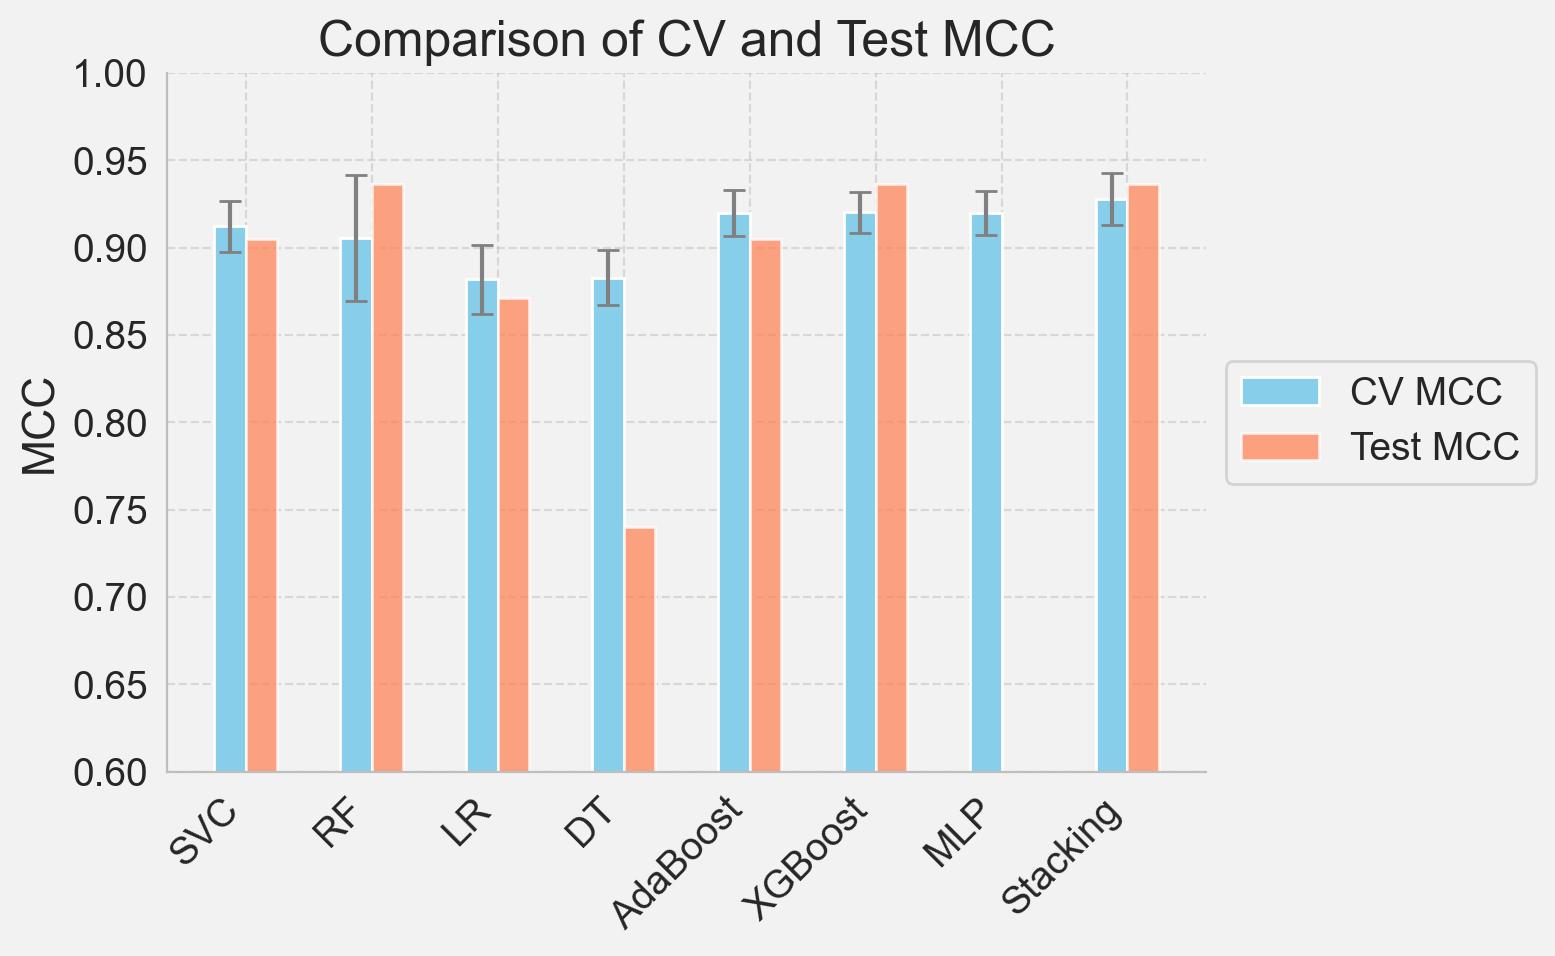

In [64]:
# Merge the DataFrames
merged_df = pd.merge(CV_Scores, Testing_scores, on='Model', how='inner')

# Rename columns and set index
merged_df = merged_df.rename(columns={'Mean MCC': 'Mean MCC_CV', 'SE MCC': 'SE MCC_CV'})
merged_df = merged_df.set_index('Model')

# Plotting
plt.figure(figsize=(8, 5))

bar_width = 0.25  # Width of each bar
index = np.arange(len(merged_df))  # Positions of the bars

# Plot CV bars with error bars
plt.bar(index, merged_df['Mean MCC_CV'], bar_width, yerr=merged_df['SE MCC_CV'],ecolor='grey', capsize=4, label='CV MCC', color='skyblue', )

# Plot Test bars, shifted to the right
plt.bar(index + bar_width, merged_df['mcc_test'], bar_width, label='Test MCC', color='coral', alpha=0.7)

# Customize the plot
plt.ylim(0.6, 1)
plt.ylabel('MCC')
plt.title('Comparison of CV and Test MCC')
plt.xticks(index + bar_width / 2, merged_df.index, rotation=45, ha='right')  # Adjust x-ticks
plt.legend()
sns.despine()
plt.grid(axis='both', linestyle='--', alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [65]:
Testing_scores.drop(columns='y_pred')

Model precision_test recall_test   f1_test  mcc_test
0       SVC            1.0    0.863636  0.926829  0.904967
1        RF            1.0    0.909091  0.952381  0.936586
2        LR           0.95    0.863636  0.904762  0.871025
3        DT       0.740741    0.909091  0.816327   0.74017
4  AdaBoost            1.0    0.863636  0.926829  0.904967
5   XGBoost            1.0    0.909091  0.952381  0.936586
6       MLP            0.0         0.0       0.0       0.0
7  Stacking            1.0    0.909091  0.952381  0.936586

# XGBoost

In [66]:
tmp = Testing_Results['XGBoost']['y_pred'] == y_test
# get indx of the wrong predictions
pos = np.where(tmp == False)[0]
# get index of X_test for the wrong predictions
wrong_idx = X_test.iloc[pos].index
DATA.loc[wrong_idx]

Age Gender Smoking Hx Smoking Hx Radiothreapy Thyroid Function  \
330   52      M     Yes         No              No        Euthyroid   
301   63      F      No         No              No        Euthyroid   

            Physical Examination Adenopathy   Pathology     Focality  \
330   Single nodular goiter-left      Right  Follicular  Multi-Focal   
301  Single nodular goiter-right         No  Follicular    Uni-Focal   

             Risk    T   N   M Stage                Response Recurred   Set  
330  Intermediate  T3a  N0  M0     I  Biochemical Incomplete      Yes  Test  
301  Intermediate  T3a  N0  M0    II           Indeterminate      Yes  Test